In [1]:
#All Required Importings
import os 
import glob
import sox
import librosa
import time
import io, json
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Audio


# All folds numbers
Folds = range(1,11) # Defining folds numbers From 1 to 10
# Path To Data as required
PathToData = '/Users/arp504/Documents/Summer2016/ML/Homework/LS_Homework2/UrbanSound8K/'
# These set names will help to label each set portion
SetNames = ['Training','Validation','Test']
# During Task 2 I will convert and save each fold in its corresponding folder according to my split

/Users/arp504/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Task 1
-----
The UrbanSound8K dataset has been downloaded, and stored in the followin path: ```UrbanSound8K/```.

**Q1.1**: There are 10 sound classes in the dataset, which are:<br>
* air conditioner<br>
* car horn<br>
* children playing<br>
* dog bark<br>
* drilling<br>
* engine idling<br>
* gun shot<br>
* jackhammer<br>
* siren<br>
* street music<br>

**Q1.2**:  A priori, I think the **siren** and **carn horn** classes will be harder for the model to distinguish because *they may have the same timbre, because these sounds are designed for coming from inside a car, with simmilar horn design and while recording them, the doppler effect will also affect both*. I also think that the **engine_idling** and **air_conditioner** classes will also be harder for the model to distinguish because *they are both engines running constantly*. I think also that the **drilling** and **jack_hammer** classes will also be harder for the model to distinguish because *they are both hitting sounds*.

**Q1.3**: Is answered in the following cell:

In [2]:
# My personal Split:
# Determining Test, Validation and Trainning Set
MyName = 'AlejandroPorcel'             # Defining My Name
TestFold = len(MyName) % 10 + 1        # Obtaining Test Fold Number
ValidationFold = TestFold % 10 + 1     # Obtaining Validation Fold Number
TrainingFolds = range(1,11)            # Assigning all Folds to Training Folds at first
del TrainingFolds[TestFold - 1]        # Deleting the test fold
del TrainingFolds[ValidationFold - 2]  # Deleting the validation fold
# I tried and it won't work with TestFold = 10, but this is not the case, my name does not give that result.
print "My personal split Based on My Name: {0}, is the following:\n\
The Test Fold is fold{1},\n\
The Validation Fold is fold{2} and\n\
The Training Folds are folds: {3}".format(MyName,TestFold,ValidationFold,TrainingFolds)

My personal split Based on My Name: AlejandroPorcel, is the following:
The Test Fold is fold6,
The Validation Fold is fold7 and
The Training Folds are folds: [1, 2, 3, 4, 5, 8, 9, 10]


# Task 2

In [3]:
# Defining Path To Data Origin
AudioFolder = PathToData + 'audio/'

# Defining Path To Data of Each Set
TrainFolder = AudioFolder + 'train/'
ValidateFolder = AudioFolder + 'validate/'
TestFolder = AudioFolder + 'test/'

#Making an arrange of Folders
SetFolders = [TrainFolder,ValidateFolder,TestFolder]

In [4]:
# Here we specify the desired output format
OutFormat = 'wav'
OutSR = 44100
OutBitDepth = 16
OutChannels = 1

In [5]:
# Total Seconds Counter
TotalWorkTime = 0
# Now get in each fold accordingly to its purpose (Train, Validate and Test)
for fold in Folds:
    # Record starting time.
    StartTime = time.time()
    # According to each fold, the input folder will change
    InputFolder = AudioFolder + 'fold{0}/'.format(fold)
    # To Use in the Set Lists (described above) and according to which fold is, Set Index to:
    if fold in TrainingFolds:
        SetIndex = 0
    elif fold == ValidationFold:
        SetIndex = 1
    elif fold == TestFold:
        SetIndex = 2
    # With Set Index defined, now we take Output Folder and NAme
    OutputFolder = SetFolders[SetIndex]
    SetName = SetNames[SetIndex]
    # Find all files in the input folder (they must all be audio files!)
    AudioFiles = glob.glob(os.path.join(InputFolder, "*.wav"))
    # Get the number of files to process
    Cant = len(AudioFiles)
    print 'Converting {0} files in fold{1}, to {2}'.format(Cant,fold,SetName)
    # Convert each file
    for af in AudioFiles:
        # If it is a ValidFile
        if os.path.isfile(af):
            # Taking out the previous extension 
            OutFile = os.path.join(OutputFolder, "{:s}.{:s}".format(os.path.splitext(os.path.basename(af))[0], OutFormat))
            tfm = sox.Transformer(af, OutFile)
            tfm.convert(samplerate=OutSR, channels=OutChannels, bitdepth=OutBitDepth)
            tfm.build()
    # Record ending time
    EndTime = time.time()
    # Get the working time of all current fold
    WorkTime =  EndTime - StartTime
    # And Adding it to Total Work Time
    TotalWorkTime = TotalWorkTime + WorkTime
    print "Fold {0} with {1} elements took {2} seconds to convert".format(fold,Cant,WorkTime)
print "All Folds took {0} seconds to convert".format(TotalWorkTime)

Converting 873 files in fold1, to Training
Fold 1 with 873 elements took 37.383756876 seconds to convert
Converting 888 files in fold2, to Training
Fold 2 with 888 elements took 30.6296200752 seconds to convert
Converting 925 files in fold3, to Training
Fold 3 with 925 elements took 29.9142959118 seconds to convert
Converting 990 files in fold4, to Training
Fold 4 with 990 elements took 40.5115740299 seconds to convert
Converting 936 files in fold5, to Training
Fold 5 with 936 elements took 33.1547119617 seconds to convert
Converting 823 files in fold6, to Test
Fold 6 with 823 elements took 23.9955730438 seconds to convert
Converting 838 files in fold7, to Validation
Fold 7 with 838 elements took 29.657460928 seconds to convert
Converting 806 files in fold8, to Training
Fold 8 with 806 elements took 26.8998098373 seconds to convert
Converting 816 files in fold9, to Training
Fold 9 with 816 elements took 30.056830883 seconds to convert
Converting 837 files in fold10, to Training
Fold 10

# Task 3

In [6]:
# According to Assignment define the parameters
SampleRate = 44100
WindowSize = 1024
NBands = 128
Nmfcc = 25
HopSize = 512
# Set to 0 the Total Work Time
TotalWorkTime = 0
# Initializing Dictionary that will contain results
mfccResults = {}

# This procedure/function obtains the raw mfcc and store it into a dictionary
def MFCC_Process(set_):
    # Record the start time
    StartTime = time.time()
    # According to Set, set the folder 
    SetFolder = SetFolders[set_]
    # Find all files in the input folder (they must all be audio files!)
    AudioFiles = glob.glob(os.path.join(SetFolder, "*.wav"))
    OutputListmfcc = []
    Cant = len(AudioFiles)
    print 'Applying MFCC to {0} files in {1} Set'.format(Cant,SetNames[set_])
    for af in AudioFiles:
        Outputmfcc = {}
        audio, sr = librosa.load(af, sr=SampleRate, mono=True)
        if sr != SampleRate:
            print "There is a Terrible Error in file {0} because the sample rate is {1} and should be {2}".format(os.path.basename(af),sr,SampleRate)
            os.exit(0)
        mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=WindowSize, hop_length=HopSize,
                                    fmax=SampleRate/2, n_mels=NBands, n_mfcc=(Nmfcc + 1))
        mfcc = mfcc[1:,:] # Discard first element as requested
        Outputmfcc['mfcc'] = mfcc
        Outputmfcc['file'] = os.path.basename(af)
        OutputListmfcc.append(Outputmfcc)
    mfccResults[SetNames[set_]] = OutputListmfcc
    #mark the end time
    EndTime = time.time()
    #calculate the total time it took to complete the work
    WorkTime =  EndTime - StartTime
    print "{0} Set with {1} elements took {2} seconds to complete".format(SetNames[set_],Cant,WorkTime)

        

In [7]:
# Make the process for each set
mfccResults={}
for i in range(0,3):
    MFCC_Process(i)
print "All Sets took {0} seconds to complete".format(TotalWorkTime)

Applying MFCC to 7071 files in Training Set
Training Set with 7071 elements took 190.69301486 seconds to complete
Applying MFCC to 838 files in Validation Set
Validation Set with 838 elements took 24.8968541622 seconds to complete
Applying MFCC to 823 files in Test Set
Test Set with 823 elements took 22.3538608551 seconds to complete
All Sets took 0 seconds to complete


# Task 4

In [8]:
# Define Metadata Path and File
metadata_path = PathToData + 'metadata/'
metadata_file = 'UrbanSound8K.csv'
#open metadata file to get labels
metadata = pd.read_csv(metadata_path + metadata_file)
#Define a GetLabel Function that queries the given filename 
def GetLabel(filename):
    md_filt = metadata[metadata['slice_file_name'] == filename]    
    return md_filt.get_value(md_filt.index[0],'classID')
#Specify the classes from metadata
labels = list(metadata[['classID','class']].drop_duplicates().sort(['classID']).reset_index(drop=True)['class'])

/Users/arp504/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [9]:
# Define each set lists of features and labels
TrainLabels = []
TrainFeatures = []
ValidateLabels = []
ValidateFeatures = []
TestLabels = []
TestFeatures = []

for set_ in SetNames:
    print "Processing {0} Set".format(set_)
    for record in mfccResults[set_]:
        mfcc = record['mfcc']
        FileName = record['file']
        Label = GetLabel(FileName)
        # Summarize the time-series (per-frame values) for each mfcc coefficient:
        # Hint: we could also compute these statistics on the delta and delta-delta
        # time series. We could also compute more statistics from each time series!
        mfccMeans = np.mean(mfcc, 1)
        mfccStdDevs = np.std(mfcc, 1)
        
        # For possible future we add this code commented
        # We could do the same for the delta features like this:
        # mfccDMeans = np.mean(np.diff(mfcc), 1)
        # mfccDStdDevs = np.std(np.diff(mfcc), 1)
    
         # Concatenate means and std. dev's into a single feature vector
        FeatureVector = np.concatenate((mfccMeans, mfccStdDevs), axis=0)
        #print("File {0} with a feature vector shape: {1}, with label {2}".format(filename,feature_vector.shape,label))
        
        # Depending on Set, it will increase labels and feature vector
        if set_ == 'Training':
            TrainLabels.append(Label)
            TrainFeatures.append(FeatureVector)
        elif set_ == 'Validation':
            ValidateLabels.append(Label)
            ValidateFeatures.append(FeatureVector)
        elif set_ == 'Test':
            TestLabels.append(Label)
            TestFeatures.append(FeatureVector)

        

Processing Training Set
Processing Validation Set
Processing Test Set


In [10]:
#Now Standarize
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(TrainFeatures)

# Apply the learned parameters to the training, validation and test sets:
TrainFeaturesScaled = scaler.transform(TrainFeatures)
ValidateFeaturesScaled = scaler.transform(ValidateFeatures)
TestFeaturesScaled = scaler.transform(TestFeatures)


# Task 5

In [11]:
# As Requested, First Using K = 5 Nearest Neighbors

# Use a K nearest neighbour classifier with K = 5
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)

# Fit (=train) the model
clf.fit(TrainFeaturesScaled, TrainLabels)

# Now lets predict the labels of the Validation data!
Predictions = clf.predict(ValidateFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(ValidateLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(ValidateLabels, Predictions)
print(cm)

Accuracy : 0.509546539379
[[83  0 14  0  0  1  0  0  1  1]
 [ 2  9 10  2  0  0  0  0  0  5]
 [ 3  3 70  0  0  2  0  0  7 15]
 [ 0  0 21 65  2  0  4  2  0  6]
 [42  1  3  3 19  1  1  4  0 26]
 [20  0 32  0  1 44  0  4  0  5]
 [ 0  0  2  1  0  0 47  0  0  1]
 [43  0  0  0 15  0  0  6  1 11]
 [ 1  2  7  0  0  2  0 10 42 13]
 [10  0 44  0  0  0  0  0  4 42]]


In [12]:
# Same with K = 3
# Use a K nearest neighbour classifier with K = 3
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

# Fit (=train) the model
clf.fit(TrainFeaturesScaled, TrainLabels)

# Now lets predict the labels of the Validation data!
Predictions = clf.predict(ValidateFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(ValidateLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(ValidateLabels, Predictions)
print(cm)

Accuracy : 0.517899761337
[[78  0 11  0  0  1  1  1  7  1]
 [ 2 11  7  3  0  0  0  0  0  5]
 [ 3  2 77  0  0  0  0  0  5 13]
 [ 0  0 20 68  2  0  2  2  1  5]
 [37  1  5  1 18  3  1  4  3 27]
 [16  0 27  3  1 49  0  3  2  5]
 [ 1  0  1  1  0  0 47  0  0  1]
 [42  0  0  0 15  0  0  6  1 12]
 [ 0  1  7  1  0  3  0 10 41 14]
 [11  0 44  2  0  0  0  0  4 39]]


In [13]:
# Same with K = 7
# Use a K nearest neighbour classifier with K = 7
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=7)

# Fit (=train) the model
clf.fit(TrainFeaturesScaled, TrainLabels)

# Now lets predict the labels of the Validation data!
Predictions = clf.predict(ValidateFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(ValidateLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(ValidateLabels, Predictions)
print(cm)

Accuracy : 0.514319809069
[[86  0 11  0  0  1  1  0  1  0]
 [ 3  9  7  2  0  0  0  0  0  7]
 [ 3  3 75  0  0  1  0  0  4 14]
 [ 0  0 16 67  1  0  5  2  2  7]
 [41  1  4  1 17  3  1  5  0 27]
 [21  0 33  0  2 40  0  6  0  4]
 [ 0  0  2  0  0  0 48  0  0  1]
 [43  0  0  0 15  0  0  6  0 12]
 [ 1  0 12  0  0  3  0  8 41 12]
 [11  0 43  0  0  0  0  0  4 42]]


In [14]:
# Same with K = 13
# Use a K nearest neighbour classifier with K = 13
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=13)

# Fit (=train) the model
clf.fit(TrainFeaturesScaled, TrainLabels)

# Now lets predict the labels of the Validation data!
Predictions = clf.predict(ValidateFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(ValidateLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(ValidateLabels, Predictions)
print(cm)

Accuracy : 0.509546539379
[[90  0  7  0  0  0  1  0  2  0]
 [ 4  7  7  2  0  0  1  0  0  7]
 [ 5  0 71  0  0  2  0  0  3 19]
 [ 0  0 21 65  3  0  4  2  1  4]
 [43  1  2  1 16  1  1  6  0 29]
 [19  0 33  1  4 40  0  4  0  5]
 [ 0  0  2  0  0  0 48  0  0  1]
 [44  0  0  0 14  0  0  6  0 12]
 [ 1  0 13  0  0  6  0  7 42  8]
 [12  0 42  0  0  0  0  0  4 42]]


In [15]:
# Using SVM
clf = svm.SVC(kernel='rbf') 
clf.fit(TrainFeaturesScaled,TrainLabels)

Predictions = clf.predict(ValidateFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(ValidateLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(ValidateLabels, Predictions)
print(cm)

Accuracy : 0.652744630072
[[81  0  0  0  0  2  0 16  0  1]
 [ 2 19  0  3  0  0  0  0  0  4]
 [ 5  0 69  0  2  4  0  1  2 17]
 [ 1  1  8 83  2  0  0  0  1  4]
 [16 13  1  5 48  0  0 15  1  1]
 [18  4  1  7  2 64  0  8  1  1]
 [ 0  0  0  6  2  0 43  0  0  0]
 [27  0  0  0 22  0  0 26  0  1]
 [ 0  1  7  3  1  5  0  8 40 12]
 [ 3  0 14  3  1  2  0  0  3 74]]


In [16]:
# Using Random Forest
num_trees = 500
rf = RandomForestClassifier(n_estimators=num_trees)
rf.fit(X=TrainFeaturesScaled, y=TrainLabels)

# generate predictions and add them to 'results'
# get accuracy (predict the class)
Prediction = rf.predict(ValidateFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(ValidateLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(ValidateLabels, Predictions)
print(cm)

Accuracy : 0.652744630072
[[81  0  0  0  0  2  0 16  0  1]
 [ 2 19  0  3  0  0  0  0  0  4]
 [ 5  0 69  0  2  4  0  1  2 17]
 [ 1  1  8 83  2  0  0  0  1  4]
 [16 13  1  5 48  0  0 15  1  1]
 [18  4  1  7  2 64  0  8  1  1]
 [ 0  0  0  6  2  0 43  0  0  0]
 [27  0  0  0 22  0  0 26  0  1]
 [ 0  1  7  3  1  5  0  8 40 12]
 [ 3  0 14  3  1  2  0  0  3 74]]


# Task 6

In [17]:
# Define each set lists of features and labels
TrainLabels = []
TrainFeatures = []
ValidateLabels = []
ValidateFeatures = []
TestLabels = []
TestFeatures = []

for set_ in SetNames:
    print "Processing {0} Set".format(set_)
    for record in mfccResults[set_]:
        mfcc = record['mfcc']
        FileName = record['file']
        Label = GetLabel(FileName)
        # Summarize the time-series (per-frame values) for each mfcc coefficient:
        # Hint: we could also compute these statistics on the delta and delta-delta
        # time series. We could also compute more statistics from each time series!
        mfccMeans = np.mean(mfcc, 1)
        mfccStdDevs = np.std(mfcc, 1)
        
        # For possible future we add this code commented
        # We could do the same for the delta features like this:
        mfccDMeans = np.mean(np.diff(mfcc), 1)
        mfccDStdDevs = np.std(np.diff(mfcc), 1)
    
         # Concatenate means and std. dev's into a single feature vector
        FeatureVector = np.concatenate((mfccMeans,mfccStdDevs,mfccDMeans,mfccDStdDevs), axis=0)
        #print("File {0} with a feature vector shape: {1}, with label {2}".format(filename,feature_vector.shape,label))
        
        # Depending on Set, it will increase labels and feature vector
        if set_ == 'Training':
            TrainLabels.append(Label)
            TrainFeatures.append(FeatureVector)
        elif set_ == 'Validation':
            ValidateLabels.append(Label)
            ValidateFeatures.append(FeatureVector)
        elif set_ == 'Test':
            TestLabels.append(Label)
            TestFeatures.append(FeatureVector)

Processing Training Set
Processing Validation Set
Processing Test Set


In [18]:
#Now Standarize
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(TrainFeatures)

# Apply the learned parameters to the training, validation and test sets:
TrainFeaturesScaled = scaler.transform(TrainFeatures)
ValidateFeaturesScaled = scaler.transform(ValidateFeatures)
TestFeaturesScaled = scaler.transform(TestFeatures)

In [19]:
# Using SVM
clf = svm.SVC(kernel='rbf') 
clf.fit(TrainFeaturesScaled,TrainLabels)

Predictions = clf.predict(ValidateFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(ValidateLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(ValidateLabels, Predictions)
print(cm)

Accuracy : 0.656324582339
[[91  0  0  0  0  1  0  8  0  0]
 [ 2 17  1  2  1  0  0  1  0  4]
 [10  0 73  1  2  0  0  1  2 11]
 [ 5  2  1 81  1  1  0  1  1  7]
 [10 13  3  3 49 10  1  8  1  2]
 [17  1  3 14  0 59  0 12  0  0]
 [ 0  7  0  3  1  0 40  0  0  0]
 [45  0  0  0  7  0  1 22  0  1]
 [ 7  4 17  1  0  1  0  2 37  8]
 [ 1  0 13  2  0  1  0  0  2 81]]


# Task 7

In [20]:
# Define each set lists of features and labels
TrainLabels = []
TrainFeatures = []
TestLabels = []
TestFeatures = []
TestFiles = []

for set_ in SetNames:
    print "Processing {0} Set".format(set_)
    for record in mfccResults[set_]:
        mfcc = record['mfcc']
        FileName = record['file']
        Label = GetLabel(FileName)
        # Summarize the time-series (per-frame values) for each mfcc coefficient:
        # Hint: we could also compute these statistics on the delta and delta-delta
        # time series. We could also compute more statistics from each time series!
        mfccMeans = np.mean(mfcc, 1)
        mfccStdDevs = np.std(mfcc, 1)
        
        # For possible future we add this code commented
        # We could do the same for the delta features like this:
        mfccDMeans = np.mean(np.diff(mfcc), 1)
        mfccDStdDevs = np.std(np.diff(mfcc), 1)
    
         # Concatenate means and std. dev's into a single feature vector
        FeatureVector = np.concatenate((mfccMeans,mfccStdDevs,mfccDMeans,mfccDStdDevs), axis=0)
        #print("File {0} with a feature vector shape: {1}, with label {2}".format(filename,feature_vector.shape,label))
        
        # Depending on Set, it will increase labels and feature vector
        if set_ == 'Training':
            TrainLabels.append(Label)
            TrainFeatures.append(FeatureVector)
        elif set_ == 'Validation':
            TrainLabels.append(Label)
            TrainFeatures.append(FeatureVector)
        elif set_ == 'Test':
            TestLabels.append(Label)
            TestFeatures.append(FeatureVector)
            TestFiles.append(TestFolder + FileName)

Processing Training Set
Processing Validation Set
Processing Test Set


In [21]:
#Now Standarize
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(TrainFeatures)

# Apply the learned parameters to the training, validation and test sets:
TrainFeaturesScaled = scaler.transform(TrainFeatures)
TestFeaturesScaled = scaler.transform(TestFeatures)

In [22]:
# Using SVM
clf = svm.SVC(kernel='rbf') 
clf.fit(TrainFeaturesScaled,TrainLabels)

Predictions = clf.predict(TestFeaturesScaled)

# We can use sklearn to compute the accuracy score
Accuracy = sklearn.metrics.accuracy_score(TestLabels, Predictions)
print "Accuracy : {0}".format(Accuracy)

# Confusion Matrix (A very rare one 10 x 10)
cm = sklearn.metrics.confusion_matrix(TestLabels, Predictions)
print(cm)

Accuracy : 0.69744835966
[[40 31  5  1 10  3  2  0  0  8]
 [ 2 25  0  0  1  0  0  0  0  0]
 [ 0  0 82  4  1  0  0  4  2  7]
 [ 3  6  4 64 11  0  3  1  3  5]
 [ 9  4  0  2 83  0  0  1  0  1]
 [41  0  0  0  1 57  0  4  0  4]
 [ 0  1  0  3  1  0 40  1  0  0]
 [12  0  0  0  0  1  0 55  0  0]
 [ 8  3  5  1  6  0  0  0 51  0]
 [ 4  3 13  0  2  0  0  1  0 77]]


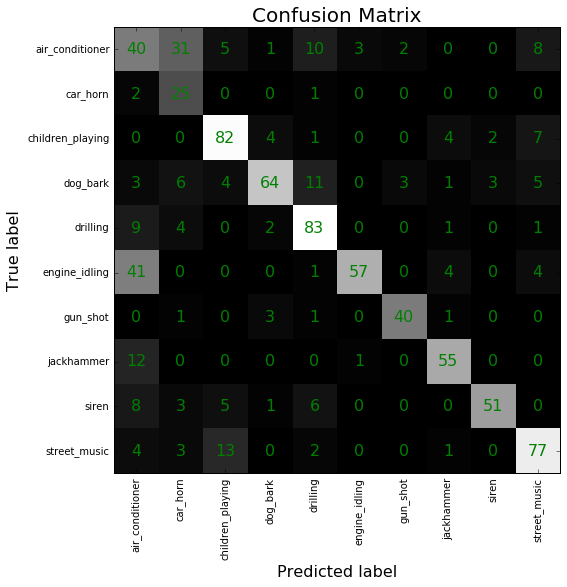

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=16, color='green',ha='center',va='center')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label',fontsize=16)
ax.set_xlabel('Predicted label',fontsize=16)
ax.set_title('Confusion Matrix',fontsize=20)
plt.show()

In [24]:
# Print results
index = 0
for filename, prediction, label in zip(TestFiles, Predictions, TestLabels):
    if prediction != label:
        print "{:d} {:s} is {:s} but was classified as {:s}".format(
            index, os.path.basename(filename), labels[label], labels[prediction])
    index += 1

0 101281-3-0-0.wav is dog_bark but was classified as drilling
1 101281-3-0-14.wav is dog_bark but was classified as drilling
2 101281-3-0-5.wav is dog_bark but was classified as drilling
3 104327-2-0-15.wav is children_playing but was classified as jackhammer
5 104327-2-0-26.wav is children_playing but was classified as jackhammer
7 104327-2-0-3.wav is children_playing but was classified as jackhammer
10 104327-2-0-4.wav is children_playing but was classified as jackhammer
14 106486-5-0-0.wav is engine_idling but was classified as jackhammer
15 106486-5-0-1.wav is engine_idling but was classified as jackhammer
16 106486-5-0-2.wav is engine_idling but was classified as jackhammer
27 108638-9-0-0.wav is street_music but was classified as drilling
28 108638-9-0-1.wav is street_music but was classified as children_playing
29 108638-9-0-2.wav is street_music but was classified as children_playing
32 108638-9-0-6.wav is street_music but was classified as drilling
44 111386-5-0-0.wav is engin

In [25]:
audio_err, _ = librosa.load(TestFiles[781], sr=SampleRate)
Audio(audio_err, rate=SampleRate)

In [26]:
audio_err, _ = librosa.load(TestFiles[815], sr=SampleRate)
Audio(audio_err, rate=SampleRate)

In [27]:
audio_err, _ = librosa.load(TestFiles[159], sr=SampleRate)
Audio(audio_err, rate=SampleRate)

In [28]:
Criticsm:
    Sugest takeout extension to get a simple wav file with no ".wav.wav"

SyntaxError: invalid syntax (<ipython-input-28-54d1eb0a734f>, line 1)